<h1 style='color:maroon'>SARIMAX model for time series forecasting</h1>

We have previously detected some seasionality in the dataset previously, the ARIMA model doesnot support seasionality, however we can use SARIMA model which uses seasonal differencing.

In [8]:
# import libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Series
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [32]:
#loading the data that we processed after eda
train = pd.read_csv('data/train.csv', parse_dates=[0], index_col=[0])
train_original = pd.read_csv('data/train_original', parse_dates=['Datetime'], index_col='Datetime')
test_original = pd.read_csv('data/test_original', parse_dates=['Datetime'], index_col='Datetime')

In [33]:
train.head()

,ID,Count,year,month,day,Hour,day_of_week,weekend
Datetime,,,,,,,,
2012-08-25,11.5,3.166667,2012.0,8.0,25.0,11.5,5.0,1.0
2012-08-26,35.5,3.666667,2012.0,8.0,26.0,11.5,6.0,1.0
2012-08-27,59.5,2.583333,2012.0,8.0,27.0,11.5,0.0,0.0
2012-08-28,83.5,2.416667,2012.0,8.0,28.0,11.5,1.0,0.0
2012-08-29,107.5,2.500000,2012.0,8.0,29.0,11.5,2.0,0.0


In [34]:
def viz_stationary(timeseries):
    #determine rolling statistics 24 hours on each day
    rolmean = timeseries.rolling(window = 24).mean()
    rolstd = timeseries.rolling(window = 24).std()
    
    #plot rolling statistics
    orig = plt.plot(timeseries, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label ='Rolling Mean')
    std = plt.plot(rolstd, color = 'black', label='Rolling Std')
    plt.legend(loc = 'best')
    plt.title("Rolling Mean and Standard Deviation")
    plt.show()
    
def dicker_test(timeseries):
    #perform dickey fuller test
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','P- Value', '#Lags Used', 'NUmber of Observation Used'])
        
    print('=======================================')
    print('Results of Dicker Fuller Test:')
    print('=======================================')
        
    for key, value in dftest[4].items():
        dfoutput['Critical value ({})'.format(key)] = value
        
    print(dfoutput)
    print('=======================================')
    print('=======================================')

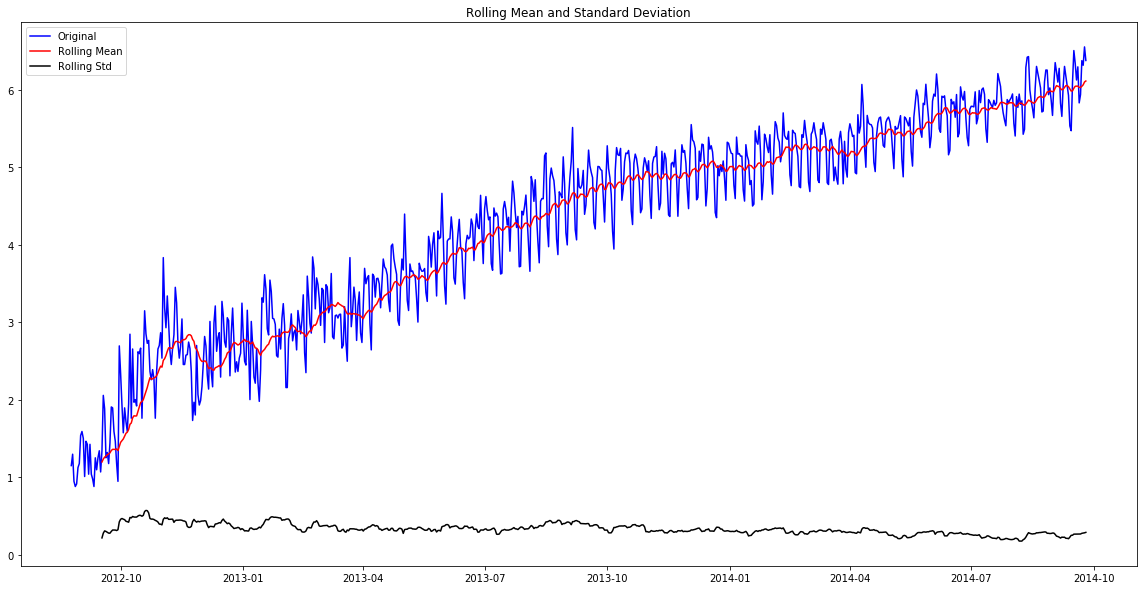

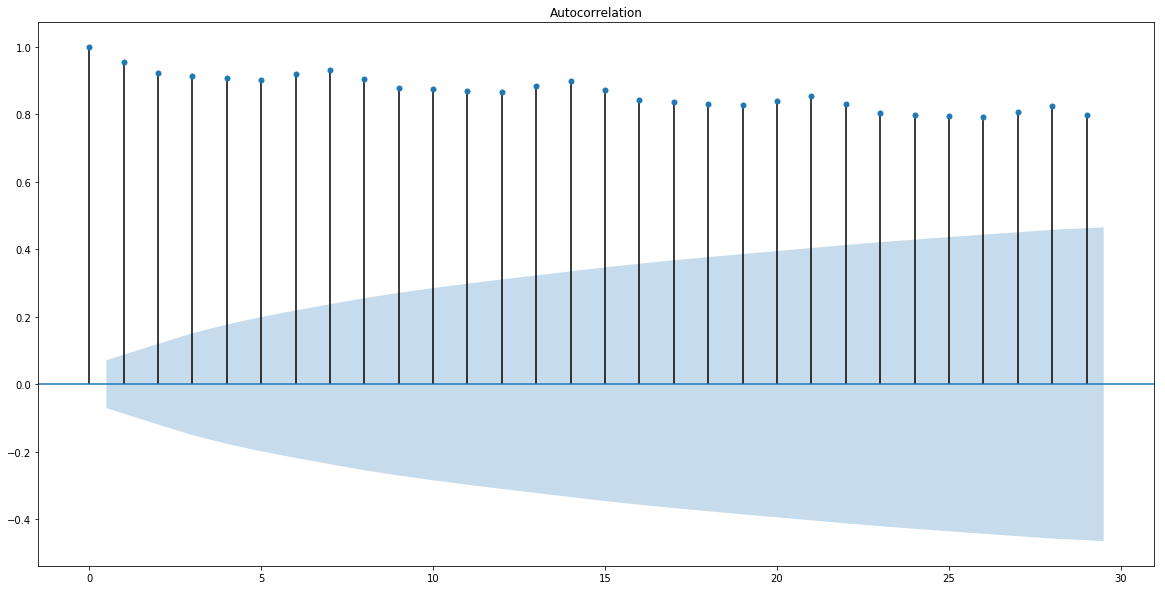

In [85]:
from matplotlib.pyplot import rcParams
from utility import evaluate_model
rcParams['figure.figsize'] = 20, 10
df = train.copy()
#applying log transformation
df_log = np.log(df.Count)

# Original Series
viz_stationary(df_log)
plot_acf(df_log)
plt.show()

### Finding seasonal period using ACF

There is a trend in a series, so we have to de trend the time series first and then find the seasonal period

In [86]:
#subtracting long rolling average over N steps
df_ = df_log - df_log.rolling(24).mean()
df_ = df_.dropna()

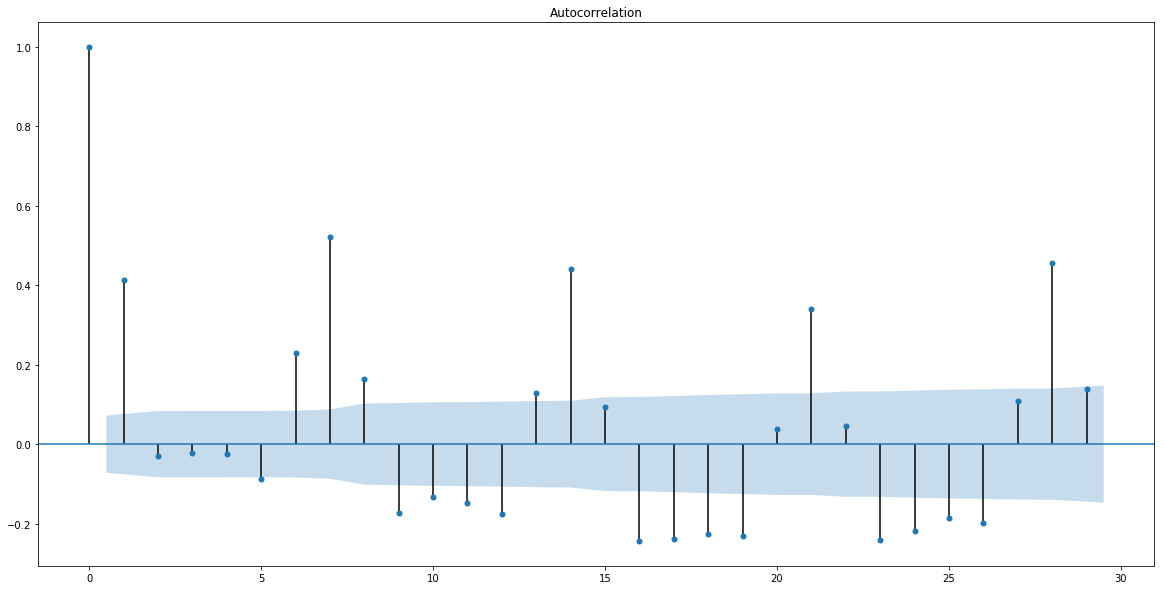

In [87]:
plot_acf(df_)
plt.show()

From the plot we can clearly see the seasonal period of 7 time Steps

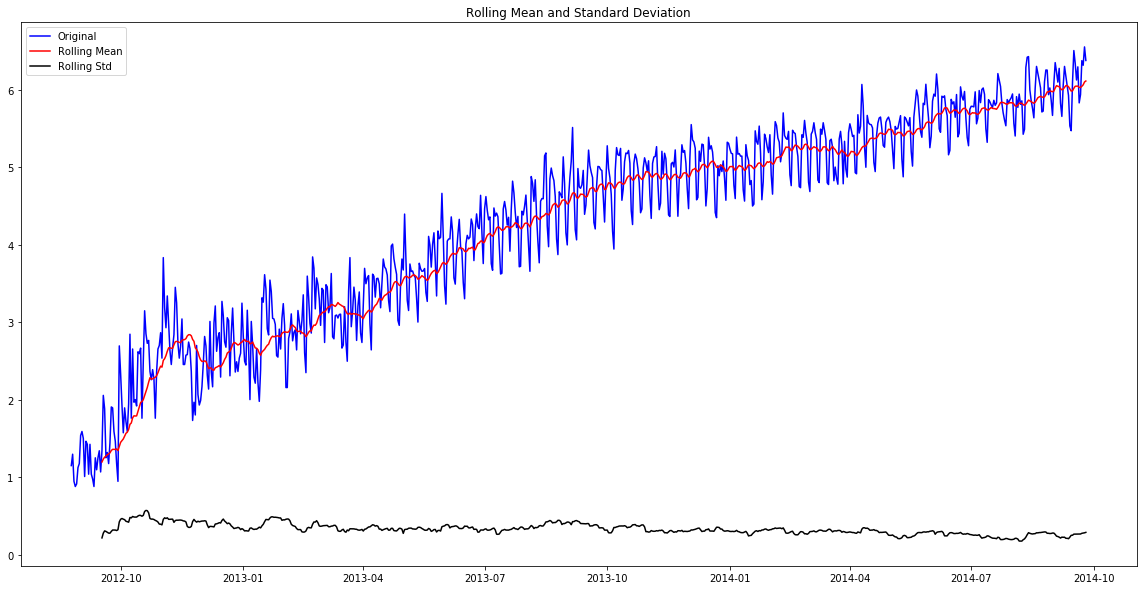

Results of Dicker Fuller Test:
Test Statistic                 -2.413296
P- Value                        0.138019
#Lags Used                     20.000000
NUmber of Observation Used    741.000000
Critical value (1%)            -3.439206
Critical value (5%)            -2.865448
Critical value (10%)           -2.568851
dtype: float64


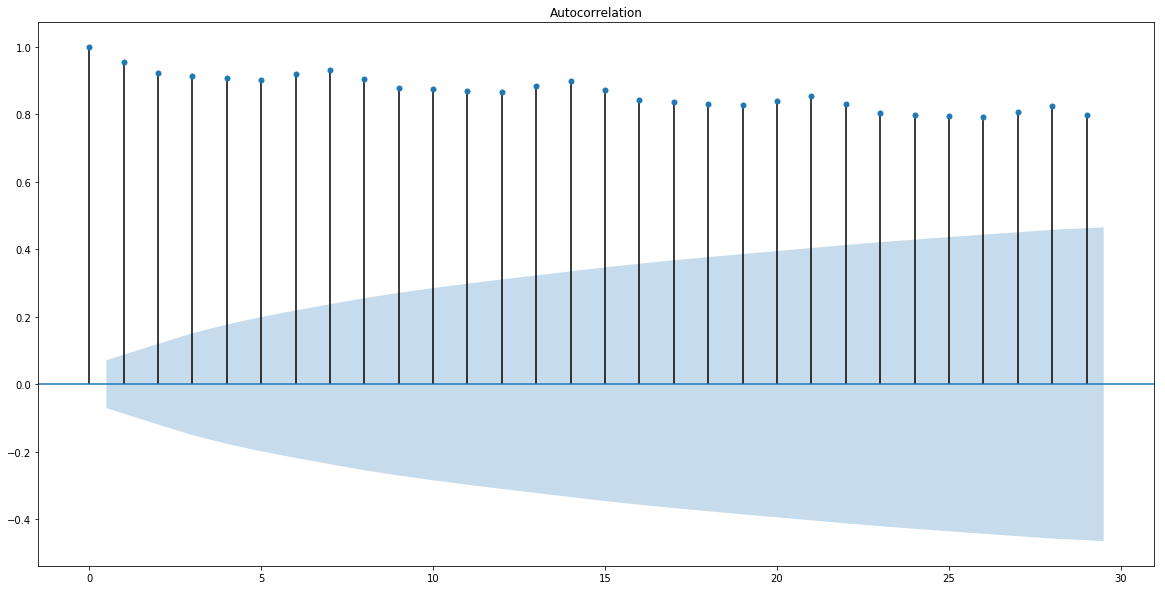

In [88]:
#Original Series
viz_stationary(df_log)
plot_acf(df_log)
dicker_test(df_log)
plt.show()

Now lets take seasonal difference for this time series data.

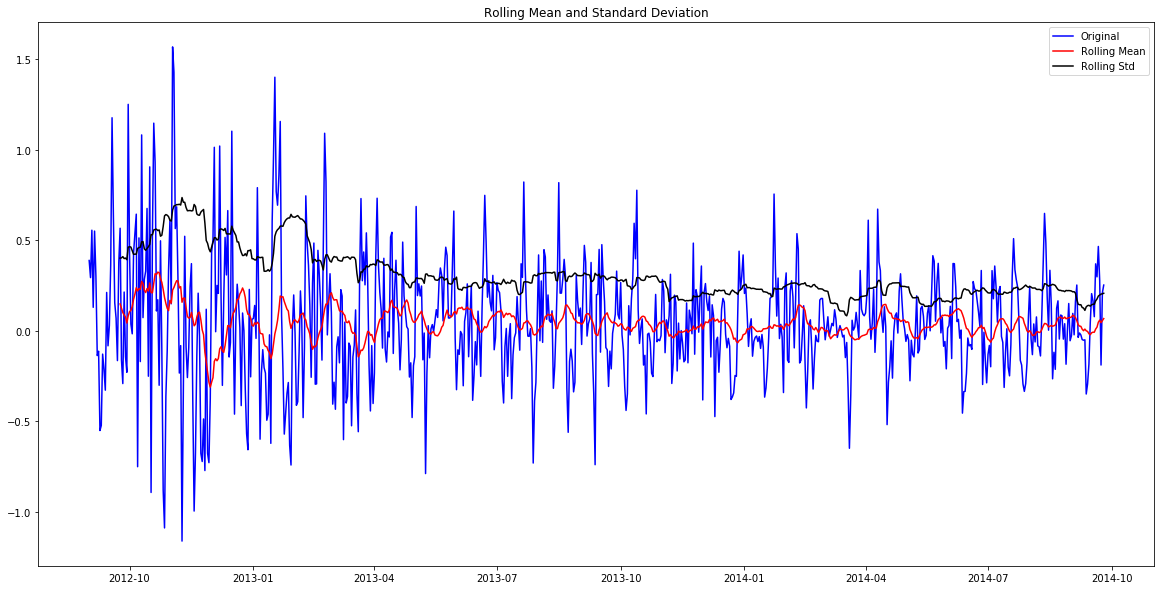

Results of Dicker Fuller Test:
Test Statistic               -9.162824e+00
P- Value                      2.506240e-15
#Lags Used                    2.000000e+01
NUmber of Observation Used    7.340000e+02
Critical value (1%)          -3.439290e+00
Critical value (5%)          -2.865486e+00
Critical value (10%)         -2.568871e+00
dtype: float64


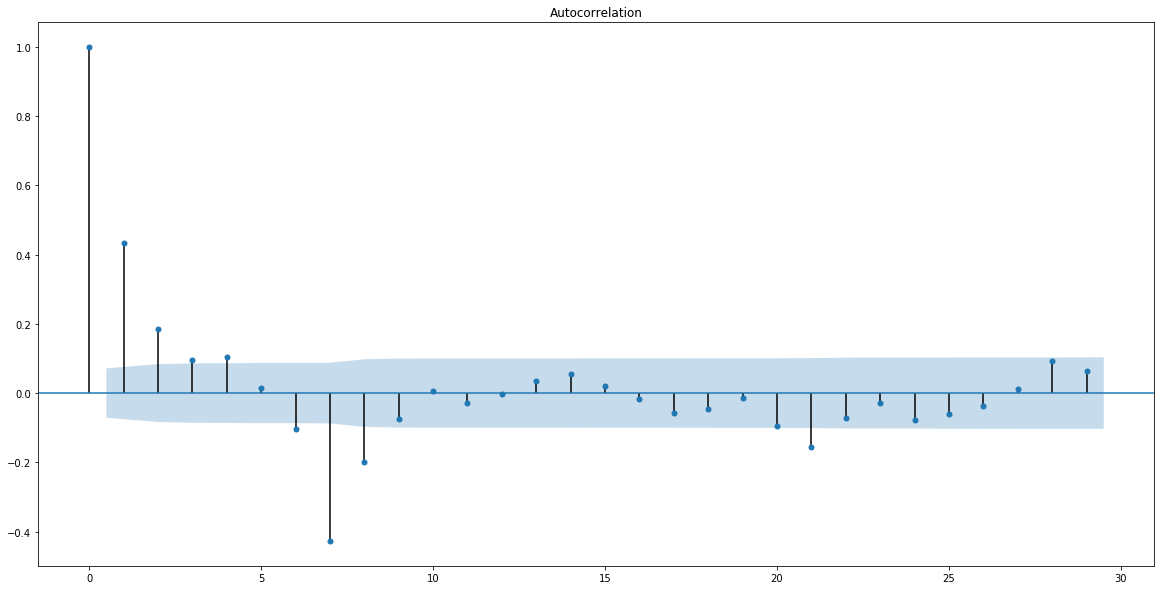

In [89]:
#taking seasonal difference
df_seasonal = df_log.diff(7)
viz_stationary(df_seasonal)
plot_acf(df_seasonal.dropna())
dicker_test(df_seasonal.dropna())
plt.show()

The time series is stationary as we can see that the p value is much lesser than 0.05.

In [90]:
from pmdarima.arima.utils import nsdiffs, ndiffs

print('ADF test Normal: {}'.format(ndiffs(df_log, test='adf')))
print('ADF test Seasonal: {}'.format(nsdiffs(train.Count, m=7,test='ch')))

ADF test Normal: 0
ADF test Seasonal: 1


Hence, we have d= 0 and D= 1

### Finding order of the model
 Seasonal ARIMA = SARIMA, tool choice for the seasonal time series. For SARIMA We need to find seasonal orders along with the regular order of AR and MA. 
SARIMA(order =(p,d,q), seasonal_order=(P,D,Q,S))

We have already found the value of d=0, D =1 and S=1 , now we find the value of remaining parameters using acf and pacf plots

#### Plotting Seasonal ACF and PACF for Regular orders p and q

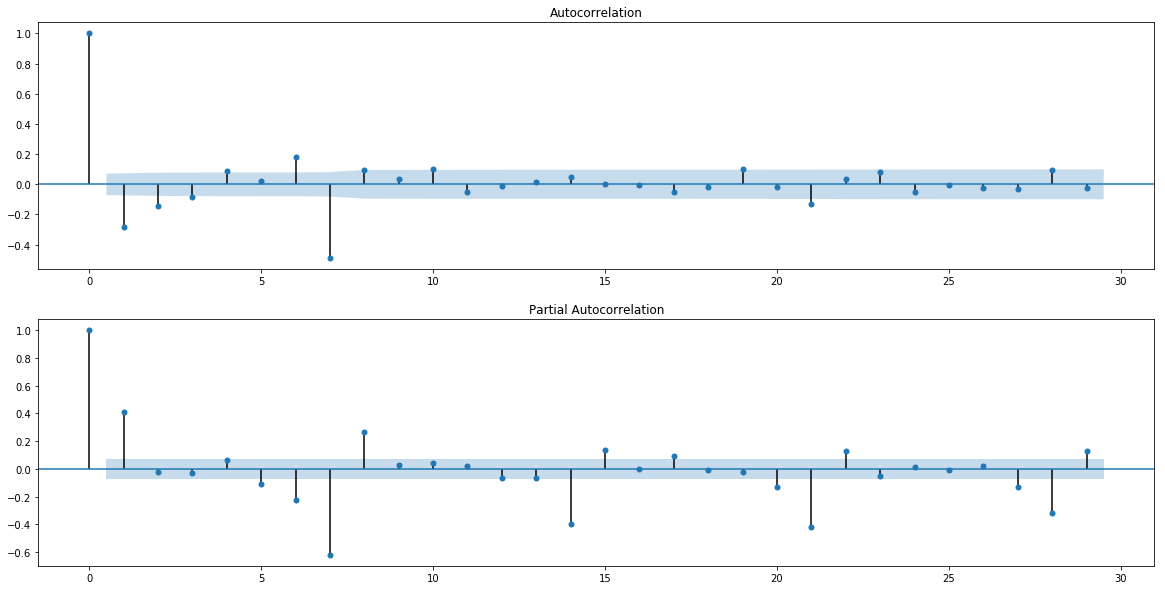

In [111]:
#finding model order
fig, (ax1, ax2) = plt.subplots(2,1)

#plot seasonal acf
plot_acf(df_seasonal.diff().dropna(), ax= ax1)

#plot seasonal pacf
plot_pacf(df_seasonal.diff(7).dropna(), ax= ax2)

plt.show()

from the above plot we can see p=1 and q=2

#### Plotting PACF and ACF for Seasonal Orders (P and Q)

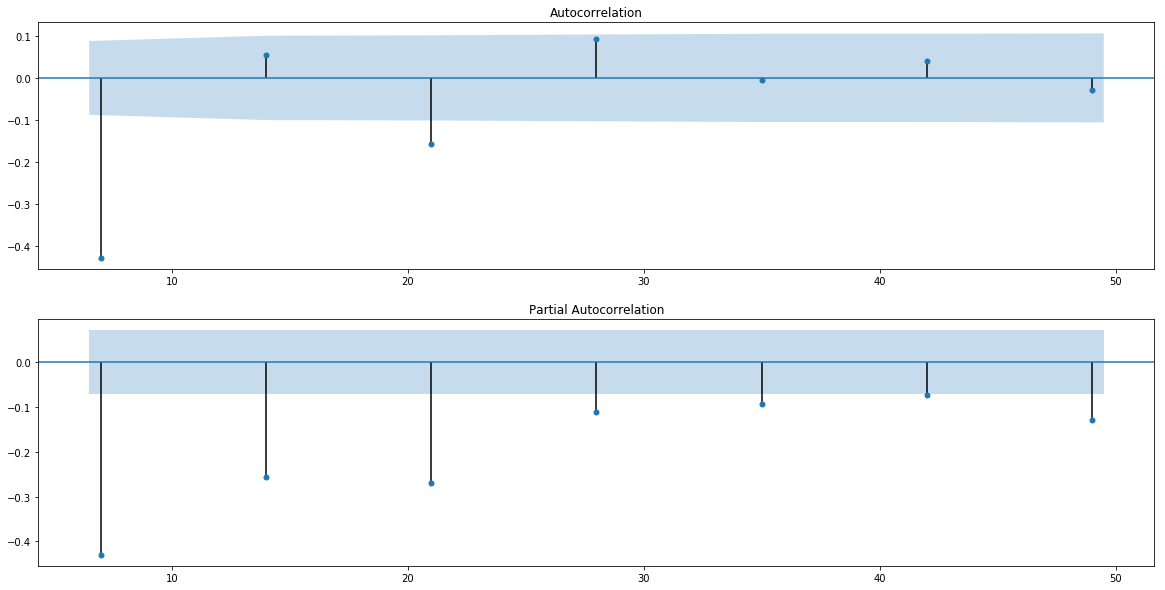

In [92]:
fig, (ax1, ax2) = plt.subplots(2,1)

#plot seasonal acf
plot_acf(df_seasonal.dropna(),zero=False ,lags=[7,14,21,28,35,42,49], ax= ax1)

#plot seasonal pacf
plot_pacf(df_seasonal.dropna(),zero=False,lags=[7,14,21,28,35,42,49], ax= ax2)

plt.show()

We can see that ACF cuts after lag 1 where as pacf tails off show we can conlude that P = 0 and Q =1

Hence the order of our model will be (1,0,2)x(0,1,1,7) according to these plots. Now lets confirm our finding.

### Searching over model orders

lets use auto_arima to find the model orders with d=0 and d=1 and compare their AIC and BIC to choose the best model

In [93]:
#setting d=0
result = pm.auto_arima(df_log,
                      seasonal=True,
                      d=0,
                      m=7,
                      D=1,
                      stepwise = True)

In [95]:
print(result.summary())

                                 Statespace Model Results                                
Dep. Variable:                                 y   No. Observations:                  762
Model:             SARIMAX(2, 0, 3)x(0, 1, 1, 7)   Log Likelihood                  22.546
Date:                           Thu, 23 Jan 2020   AIC                            -29.092
Time:                                   16:32:41   BIC                              7.922
Sample:                                        0   HQIC                           -14.834
                                           - 762                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0027      0.001      1.924      0.054   -5.12e-05       0.006
ar.L1          0.1710      0.130      1.315

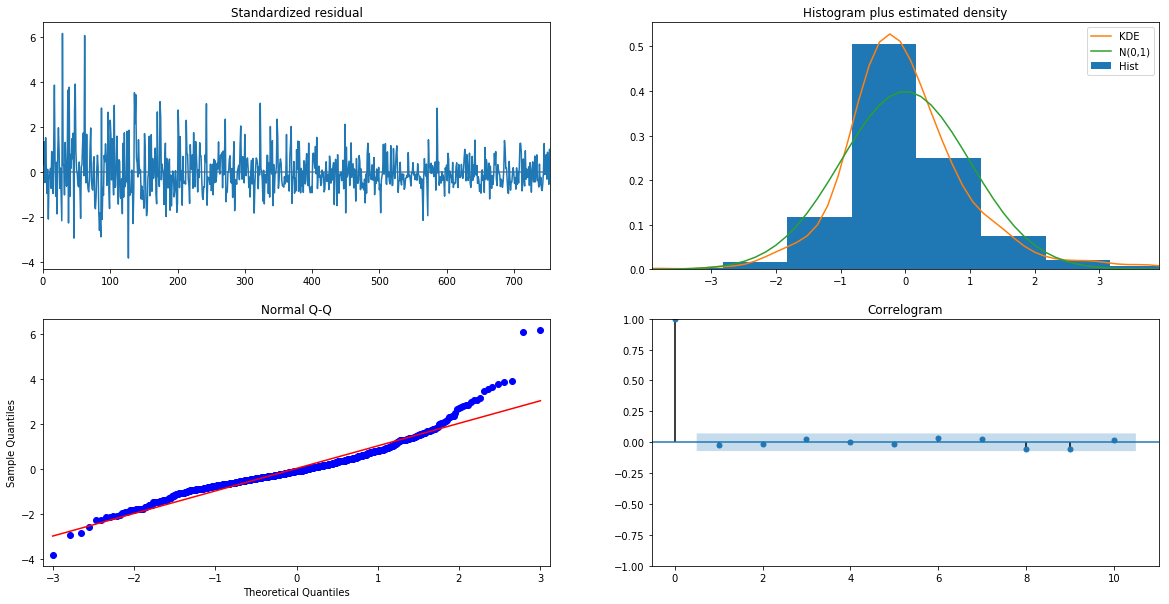

In [96]:
result.plot_diagnostics()
plt.show()

In [97]:
#setting d=1
result = pm.auto_arima(df_log,
                      seasonal=True,
                      m=7,
                      d=1,
                      D=1,
                      stepwise = True)

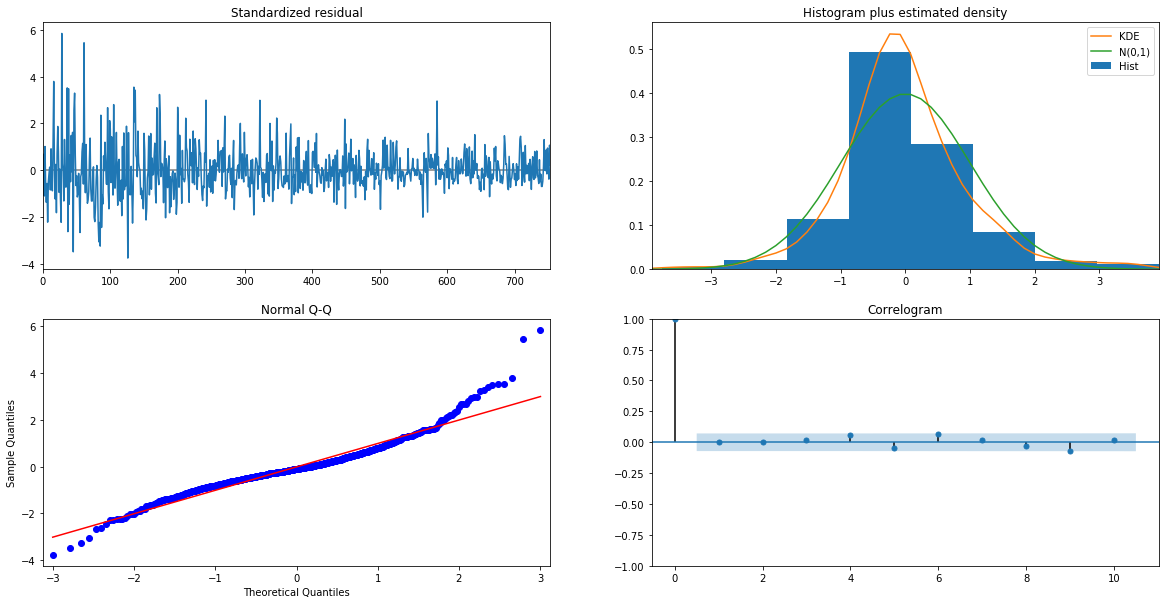

In [98]:
result.plot_diagnostics()
plt.show()

In [99]:
print(result.summary())

                                 Statespace Model Results                                
Dep. Variable:                                 y   No. Observations:                  762
Model:             SARIMAX(0, 1, 3)x(0, 1, 1, 7)   Log Likelihood                  14.449
Date:                           Thu, 23 Jan 2020   AIC                            -16.899
Time:                                   16:36:10   BIC                             10.854
Sample:                                        0   HQIC                            -6.208
                                           - 762                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0001      0.000     -0.469      0.639      -0.001       0.000
ma.L1         -0.4721      0.026    -18.038

We can see that when we set d=0 the both the AIC and BIC are lesser compared to when d = 1. So we use our final model order as
SARIMAX(2, 0, 3)x(0, 1, 1, 7). Now lets try both of these models and compare their performance

In [112]:
#creating training and test
x = int(0.85*len(df_log))
train = df_log[:x]
valid = df_log[x:]

In [141]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

#fitting the sarima model
model = SARIMAX(train, order=(2,0,3), seasonal_order=(0,1,1,7))
results = model.fit()

model_alt = SARIMAX(train, order=(1,0,2), seasonal_order=(0,1,1,7))
results_alt = model_alt.fit()

In [116]:
#Aic and Bic
print("===AIC a(2,0,3)====")
print(results.aic)

#Aic and Bic
print("===AIC (1,0,2)====")
print(results_alt.aic)

===AIC a(2,0,3)====
56.33341774614229
===AIC (1,0,2)====
58.07636382360559


In [119]:
print(results.summary())

                                 Statespace Model Results                                
Dep. Variable:                             Count   No. Observations:                  647
Model:             SARIMAX(2, 0, 3)x(0, 1, 1, 7)   Log Likelihood                 -21.167
Date:                           Thu, 23 Jan 2020   AIC                             56.333
Time:                                   17:38:50   BIC                             87.564
Sample:                               08-25-2012   HQIC                            68.455
                                    - 06-02-2014                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1689      0.125      1.351      0.177      -0.076       0.414
ar.L2          0.8207      0.125      6.579

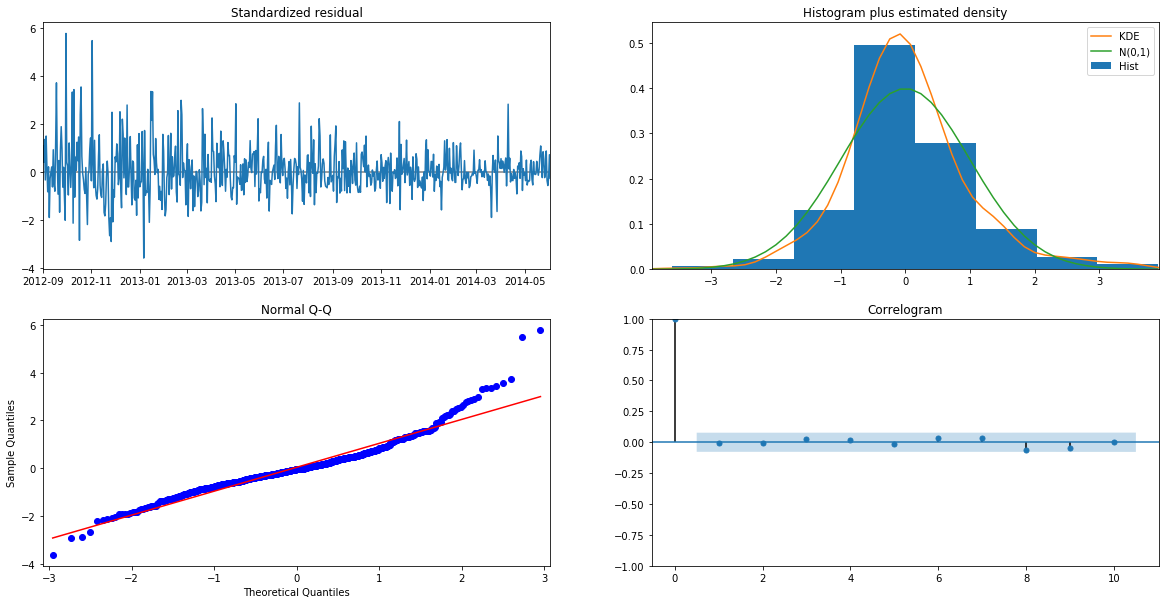

In [142]:
results.plot_diagnostics()
plt.show()

The ACF has no lags above the siginificance limit and the other plots also seems pretty good which suggest that our modelling is going good.

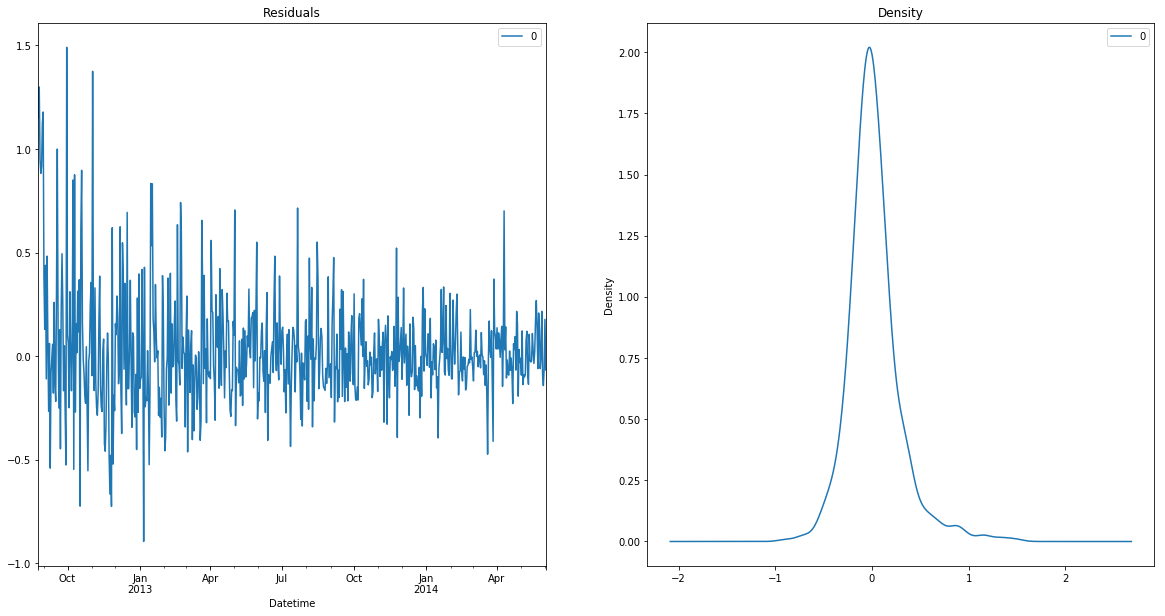

In [120]:
#plot the residuals errors
residuals = pd.DataFrame(results.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax = ax[0])
residuals.plot(kind='kde',title='Density', ax=ax[1])
plt.show()

The residual error also seems fine with zero mean and uniform variance.

In [143]:
#making forecast with 95% confidence
forecast = results.get_forecast(len(valid), alpha = 0.05)

#forecast mean
valid_forecast = forecast.predicted_mean

#get the confidence intervals of forecast
confidence_intervals = forecast.conf_int()

lower_conf = confidence_intervals['lower Count']
upper_conf = confidence_intervals['upper Count']

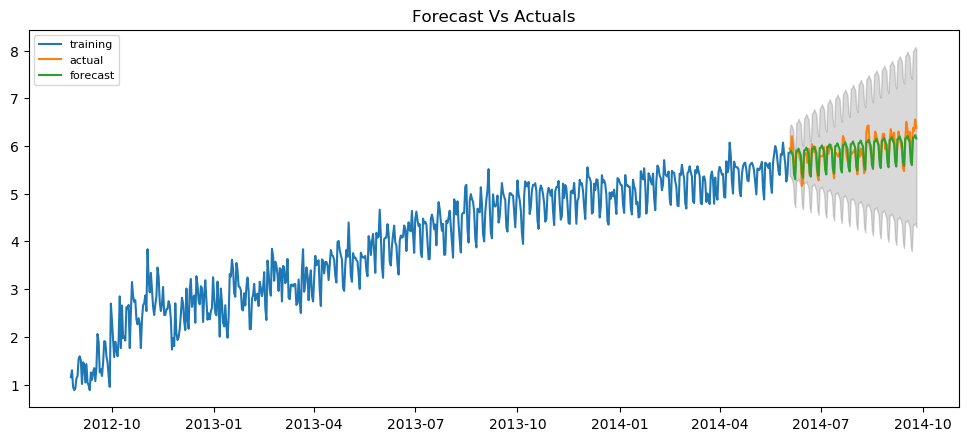

In [144]:
#plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label = 'training')
plt.plot(valid, label='actual')
plt.plot(valid_forecast, label='forecast')
plt.fill_between(lower_conf.index, lower_conf,
                 upper_conf,color = 'k', alpha =.15)
plt.title('Forecast Vs Actuals')
plt.legend(loc = 'upper left', fontsize=8)
plt.show()

The forecasted value seems very closer to the actual ones. 

In [133]:
evaluate_model(mean_forecast,valid.values)

Evaluation Metrics:
--------------------
RMS:0.16095400435465765
MAPE:0.02264006371099455
MPE:-0.0008149216343713328
--------------------


The RMS value also has gone down by half and same with the MAPE wich is just 2.2%, indicating our model is 97.8% accurate for making preditctions of the remaining 15% of the observations

### Making final predicitons

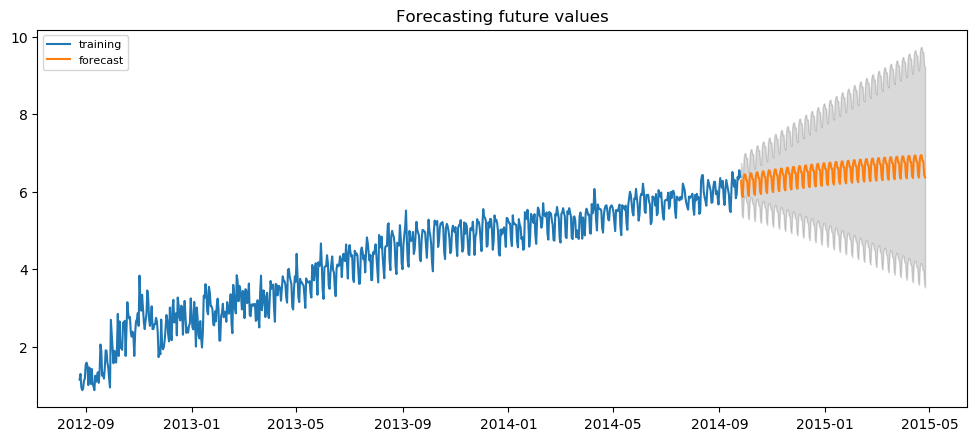

In [146]:
test = pd.read_csv('data/test.csv', parse_dates=['Datetime'], index_col='Datetime')

model = SARIMAX(df_log, order=(2,0,3), seasonal_order=(0,1,1,7))
results = model.fit()

#making forecast with 95% confidence
final_forecast = results.get_forecast(len(test), alpha = 0.05)

#forecast mean
mean_forecast = final_forecast.predicted_mean

#get the confidence intervals of forecast
confidence_intervals = final_forecast.conf_int()

lower_conf = confidence_intervals['lower Count']
upper_conf = confidence_intervals['upper Count']

plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_log, label = 'training')
# plt.plot(test, label='actual')
plt.plot(mean_forecast, label='forecast')
plt.fill_between(lower_conf.index, lower_conf,
                 upper_conf,color = 'k', alpha =.15)
plt.title('Forecasting future values')
plt.legend(loc = 'upper left', fontsize=8)
plt.show()

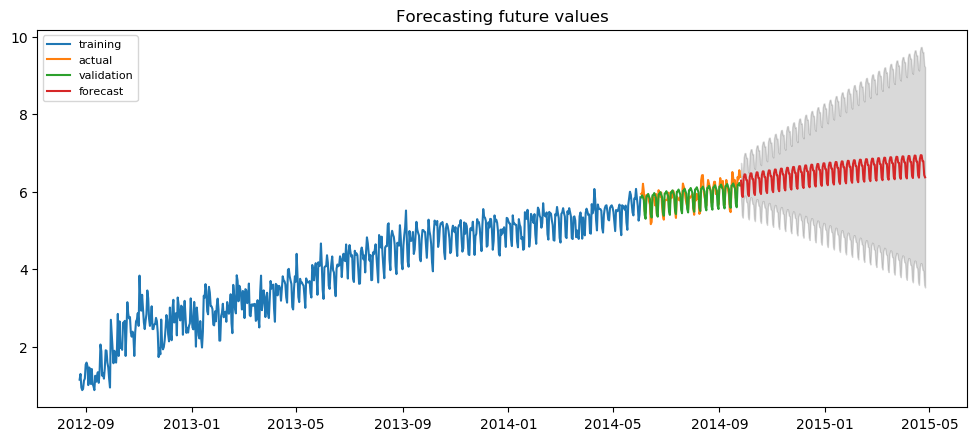

In [147]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label = 'training')
plt.plot(valid, label='actual')
plt.plot(valid_forecast, label='validation')
plt.plot(mean_forecast, label='forecast')
plt.fill_between(lower_conf.index, lower_conf,
                 upper_conf,color = 'k', alpha =.15)
plt.title('Forecasting future values')
plt.legend(loc = 'upper left', fontsize=8)
plt.show()